# Quasi static forces from spiral model test

# Purpose
Calculating the quasi static forces from a model test by assuming the added masses. This can then be compared to the static VCT calculations.

# Setup

In [1]:
# %load imports.py
# %load imports.py
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False  ## (To fix autocomplete)

## External packages:
import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)

import numpy as np
import os
import matplotlib.pyplot as plt
#if os.name == 'nt':
#    plt.style.use('presentation.mplstyle')  # Windows

import plotly.express as px 
import plotly.graph_objects as go

import seaborn as sns
import sympy as sp
from sympy.physics.mechanics import (dynamicsymbols, ReferenceFrame,
                                      Particle, Point)
from sympy.physics.vector.printing import vpprint, vlatex
from IPython.display import display, Math, Latex
from vessel_manoeuvring_models.substitute_dynamic_symbols import run, lambdify

import pyro

import sklearn
import pykalman
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import statsmodels.api as sm

from scipy.integrate import solve_ivp

## Local packages:
from vessel_manoeuvring_models.data import mdl
from vessel_manoeuvring_models.models import linear_vmm
import vessel_manoeuvring_models.nonlinear_vmm_equations as eq
import vessel_manoeuvring_models.models.linear_vmm as model
from vessel_manoeuvring_models.symbols import *
import vessel_manoeuvring_models.symbols as symbols
from vessel_manoeuvring_models import prime_system
from vessel_manoeuvring_models.models import regression
from vessel_manoeuvring_models.visualization.plot import track_plot
from vessel_manoeuvring_models.equation import Equation

Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 462 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 463 ('figure.dpi       : 100        ## figure dots per inch')


# Methodology
Generally:

$ F = m \cdot a $

if $m$ (including added mass) can is known $F$ should be possible to calculate from a dynamic model test.

For the ship in the Y-direction this can be written as:

## Y:

In [2]:
Math(vlatex(eq.Y_eom))

<IPython.core.display.Math object>

In [3]:
Math(vlatex(eq.Y_eq))

<IPython.core.display.Math object>

where $Y_{qs}$ is the quasi static force that can be obtained from the model tests as:

In [4]:
eq_Y_qs = sp.Eq(Y_qs,
      sp.solve(eq.Y_eq, Y_qs)[0])
Math(vlatex(eq_Y_qs))

<IPython.core.display.Math object>

In [5]:
subs = {value:key for key,value in eq.p.items()}
Y_qs_lambda = lambdify(eq_Y_qs.subs(subs).rhs)

## X:

In [6]:
eq_X_qs = sp.Eq(X_qs,
      sp.solve(eq.X_eq, X_qs)[0])
Math(vlatex(eq_X_qs))

<IPython.core.display.Math object>

In [7]:
X_qs_lambda = lambdify(eq_X_qs.subs(subs).rhs)

## N:

In [8]:
eq_N_qs = sp.Eq(N_qs,
      sp.solve(eq.N_eq, N_qs)[0])
Math(vlatex(eq_N_qs))

<IPython.core.display.Math object>

In [9]:
N_qs_lambda = lambdify(eq_N_qs.subs(subs).rhs)

# Quasi static forces from model tests

## Load test

In [10]:
df_runs = mdl.runs()

In [11]:
df_runs_selected = df_runs.groupby(by='test_type').get_group('rodergrundvinkel')

In [12]:
def load_run(id):
    
    df, units, meta_data = mdl.load(id=id, dir_path='../data/processed/kalman')
    df.index = df.index.total_seconds()
    df = df.iloc[1500:-100].copy()
    df.index-=df.index[0]
    df.sort_index(inplace=True)
    df['-delta'] = -df['delta']
    df['V'] = np.sqrt(df['u']**2 + df['v']**2)
    return df, units, meta_data

In [13]:
df = pd.DataFrame()
for id, _ in df_runs_selected.iterrows():
    
    df_,units, meta_data = load_run(id=id)
    df_['id'] = id
    df_['t'] = df_.index
    df = df.append(df_, ignore_index=True)
    

In [14]:
meta_data['rho']=1000
meta_data['mass'] = meta_data['Volume']*meta_data['rho']
meta_data.dropna()

A0                                                               0.722775
KXX                                                              0.331311
KZZ                                                              1.253641
TA                                                               0.206311
TF                                                               0.206311
Volume                                                           0.441027
beam                                                             0.946602
comment                                                  Rodergrundvinkel
date                                                           2020-09-22
facility                                                              MDL
file_path_hdf5          \\sspa.local\lab\MeasuredataMDL\40199079\001\0...
gm                                                               0.136092
kg                                                               0.438908
lcg                                   

In [15]:
df.head()

,Arr/Ind/Arr,Arr/Ind/Fri,Fan/Aft/Angle,Fan/Aft/AngleOrder,Fan/Aft/Fx,Fan/Aft/FxOrder,Fan/Aft/Rpm,Fan/Aft/RpmOrder,Fan/ForceFactor,Fan/Fore/Angle,Fan/Fore/AngleOrder,Fan/Fore/Fx,Fan/Fore/FxOrder,Fan/Fore/Rpm,Fan/Fore/RpmOrder,Hull/Acc/X1,Hull/Acc/Y1,Hull/Acc/Y2,Hull/Acc/Z1,Hull/Acc/Z2,Hull/Acc/Z3,Prop/PS/Rpm,Prop/PS/Thrust,Prop/PS/Torque,Prop/SB/Rpm,Prop/SB/Thrust,Prop/SB/Torque,delta,Rudder/MaxAngle,Rudder/Rate,Wind/GWA,lab/WaveHeight,roll,pitch,psi,x0,y0,z0,x01d_gradient,y01d_gradient,z01d_gradient,z02d_gradient,psi1d_gradient,x0_filtered,x01d,x02d,y0_filtered,y01d,y02d,psi_filtered,psi1d,psi2d,u,v,w,u1d,v1d,w1d,r,r1d,beta,-delta,V,id,t
0,0.0,1.0,1.550702,1.550863,0.707800,26.397204,1.708627,78.630802,1.0,0.891904,0.891913,-0.243083,26.397204,3.879334,82.680682,0.007557,-0.021825,-0.062482,-0.022542,-0.010069,0.016267,9.598900,5.392061,-0.132701,9.539582,5.439737,0.111214,0.000765,0.645772,14.89,-0.959931,0.000025,0.002852,0.000098,-0.038834,19.905762,-0.166187,0.002630,0.425136,-0.052977,-0.000030,-0.174699,-0.004366,19.904251,0.953834,-0.000153,-0.165973,-0.024921,-0.002359,-0.038804,-0.002785,0.000038,0.954082,0.012101,-0.000030,-0.000061,-0.002363,-0.174699,-0.002785,0.000038,-0.012683,-0.000765,0.954159,22612,0.000000
1,0.0,1.0,1.550689,1.550863,0.832092,26.397204,0.049076,78.629750,1.0,0.891904,0.891913,-0.276007,26.397204,4.979269,82.678395,-0.014367,0.003961,-0.049576,-0.026407,0.009273,0.035600,9.614405,5.496306,-0.133718,9.558165,5.357585,0.111053,0.003258,0.645772,14.89,-0.959931,0.000025,0.002857,0.000198,-0.038834,19.905737,-0.166273,0.002655,0.977827,-0.007614,0.000051,0.016388,0.000000,19.910451,0.955463,-0.000790,-0.166199,-0.024655,-0.002361,-0.038822,-0.002734,0.000041,0.955700,0.012447,0.000051,-0.000697,-0.002390,0.016388,-0.002734,0.000041,-0.013024,-0.003258,0.955781,22612,0.010014
2,0.0,1.0,1.550702,1.550863,0.643086,26.397204,1.940192,78.629750,1.0,0.891904,0.891913,0.002907,26.397204,3.146044,82.678395,0.008202,-0.030850,-0.041187,0.023197,0.025390,0.008533,9.589383,5.617060,-0.131783,9.496586,5.334502,0.112409,0.006707,0.645772,14.89,-0.959931,0.000025,0.002957,0.000102,-0.038834,19.925255,-0.166339,0.002632,1.476426,-0.004833,0.000298,-0.012717,0.004355,19.923492,0.956957,-0.000152,-0.166313,-0.024494,-0.002341,-0.038824,-0.002706,0.000048,0.957187,0.012668,0.000298,-0.000061,-0.002345,-0.012717,-0.002706,0.000048,-0.013234,-0.006707,0.957270,22612,0.019997
3,0.0,1.0,1.550723,1.550792,0.333526,26.398565,1.361279,78.629750,1.0,0.891904,0.891911,0.408881,26.398565,1.042659,82.678395,0.040442,-0.072107,-0.032152,0.033505,-0.005556,-0.046244,9.575627,5.726926,-0.127613,9.522613,5.358169,0.114567,0.010340,0.645772,14.89,-0.959931,0.000025,0.002912,0.000223,-0.038746,19.935228,-0.166369,0.002661,0.949507,-0.004254,-0.000205,0.006840,-0.004366,19.933983,0.956133,0.000013,-0.166389,-0.024535,-0.002312,-0.038811,-0.002722,0.000058,0.956365,0.012583,-0.000205,0.000102,-0.002310,0.006840,-0.002722,0.000058,-0.013156,-0.010340,0.956448,22612,0.030004
4,0.0,1.0,1.550716,1.550935,0.223303,26.395842,1.206902,78.630802,1.0,0.891911,0.891915,0.592257,26.395842,4.786298,82.680682,0.010781,-0.017312,-0.011502,0.028995,0.036995,0.026578,9.497092,5.778784,-0.122480,9.541165,5.413140,0.116733,0.009602,0.645772,14.89,-0.959931,0.000025,0.002870,0.000086,-0.038921,19.944255,-0.166424,0.002627,0.454316,-0.004847,0.000434,-0.003581,-0.013079,19.942663,0.955298,-0.000155,-0.166496,-0.024784,-0.002288,-0.038894,-0.002726,0.000048,0.955540,0.012381,0.000434,-0.000066,-0.002292,-0.003581,-0.002726,0.000048,-0.012956,-0.009602,0.955620,22612,0.040007


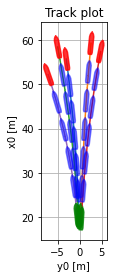

In [16]:
from vessel_manoeuvring_models.visualization.plot import track_plot
fig,ax=plt.subplots()
#fig.set_size_inches(10,10)
for id,group in df.groupby(by='id'):
    track_plot(df=group, lpp=meta_data.lpp, x_dataset='x0', y_dataset='y0',  psi_dataset='psi', beam=meta_data.beam, ax=ax);

# Ship parameters

In [17]:
T_ = (meta_data.TA + meta_data.TF)/2
L_ = meta_data.lpp
m_ = meta_data.mass
rho_ = meta_data.rho
B_ = meta_data.beam
CB_ = m_/(T_*B_*L_*rho_)
I_z_ = m_*meta_data.KZZ**2

ship_parameters = {
        'T' : T_,
        'L' : L_,
        'CB' :CB_,
        'B' : B_,
        'rho' : rho_,
        'x_G' : 0,  # motions are expressed at CG
        'm' : m_,
        'I_z': I_z_, 
        'volume':meta_data.Volume,
    }

ps = prime_system.PrimeSystem(**ship_parameters)  # model

scale_factor = meta_data.scale_factor
ps_ship = prime_system.PrimeSystem(L=ship_parameters['L']*scale_factor, rho=meta_data['rho'])  # ship

In [18]:
ship_parameters

{'T': 0.2063106796116504,
 'L': 5.014563106796117,
 'CB': 0.45034232324249973,
 'B': 0.9466019417475728,
 'rho': 1000,
 'x_G': 0,
 'm': 441.0267843660858,
 'I_z': 693.124396594905,
 'volume': 0.4410267843660858}

# Brix parameters

In [19]:
def calculate_prime(row, ship_parameters):
    return run(function=row['brix_lambda'], inputs=ship_parameters)

mask = df_parameters['brix_lambda'].notnull()
df_parameters.loc[mask,'brix_prime'] = df_parameters.loc[mask].apply(calculate_prime, ship_parameters=ship_parameters, axis=1)
df_parameters['brix_prime'].fillna(0, inplace=True)

In [20]:
df_parameters['brix_prime']

Xu           0.000000
Xudot        0.000179
Xv           0.000000
Xvdot        0.000000
Xr           0.000000
Xrdot        0.000000
Xdelta       0.000000
Xdeltadot    0.000000
Yu           0.000000
Yudot        0.000000
Yv          -0.009713
Yvdot       -0.006109
Yr           0.002402
Yrdot       -0.000303
Ydelta       0.000000
Ydeltadot    0.000000
Nu           0.000000
Nudot        0.000000
Nv          -0.003184
Nvdot       -0.000128
Nr          -0.001719
Nrdot       -0.000299
Ndelta       0.000000
Ndeltadot    0.000000
Name: brix_prime, dtype: float64

In [21]:
df['Y_qs'] = run(Y_qs_lambda, inputs=ship_parameters, **df, **df_parameters['brix_prime'])
df['X_qs'] = run(X_qs_lambda, inputs=ship_parameters, **df, **df_parameters['brix_prime'])
df['N_qs'] = run(N_qs_lambda, inputs=ship_parameters, **df, **df_parameters['brix_prime'])

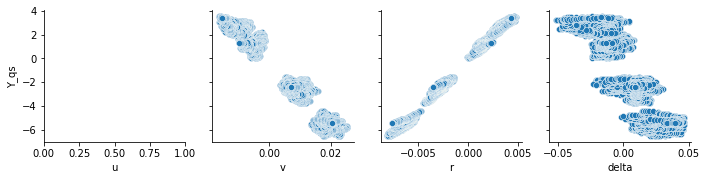

In [22]:
g = sns.PairGrid(df, x_vars=['u','v','r','delta'], y_vars=['Y_qs'])
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=3, legend=False)

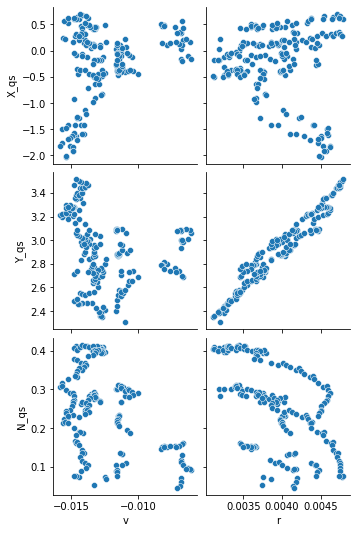

In [23]:
mask = df['delta'] <= df['delta'].quantile(q=0.01)
df_min = df.loc[mask].copy()
sns.pairplot(df_min, x_vars=['v','r'], y_vars=['X_qs','Y_qs','N_qs'])

<AxesSubplot:>

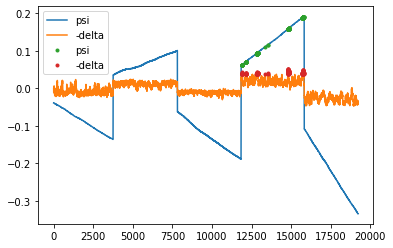

In [24]:
fig,ax=plt.subplots()
df.plot(y=['psi','-delta'], ax=ax)
df_min.plot(y=['psi','-delta'], style='.', ax=ax)

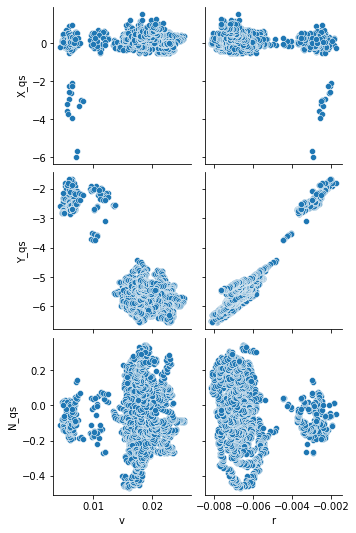

In [25]:
mask = df['delta'] >= df['delta'].quantile(q=0.85)
df_max = df.loc[mask].copy()
sns.pairplot(df_max, x_vars=['v','r'], y_vars=['X_qs','Y_qs','N_qs'])

<AxesSubplot:>

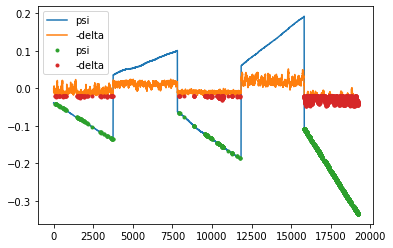

In [26]:
fig,ax=plt.subplots()
df.plot(y=['psi','-delta'], ax=ax)
df_max.plot(y=['psi','-delta'], style='.', ax=ax)

# Regression

## N

In [27]:
Math(vlatex(eq.N_qs_eq))

<IPython.core.display.Math object>

In [28]:
interesting = ['u','v','r','delta','X_qs','Y_qs','N_qs']
df_prime = ps.prime(df[interesting], U=df['V'])

In [29]:
N_ = sp.symbols('N_')
diff_eq_N = regression.DiffEqToMatrix(ode=eq.N_qs_eq.subs(N_qs,N_), 
                                      label=N_, base_features=[delta,u,v,r])

In [30]:
diff_eq_N.eq_beta

Eq(beta, Matrix([
[N_{\delta}],
[     N_{r}],
[     N_{u}],
[     N_{v}]]))

In [31]:
Math(vlatex(diff_eq_N.eq_X))

<IPython.core.display.Math object>

In [32]:
diff_eq_N.eq_y

Eq(y, N_)

In [33]:
diff_eq_N.y_lambda

<function _lambdifygenerated(N_)>

In [34]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std
def show_pred(X,y,results, label):
    
    display(results.summary())
    
    X_ = X
    y_ = y
    y_pred = results.predict(X_)
    
    prstd, iv_l, iv_u = wls_prediction_std(results, exog=X_, alpha=0.05)
    #iv_l*=-1 
    #iv_u*=-1
    
    fig,ax=plt.subplots()
    ax.plot(X_.index,y_, label='Numerical gradient from model test')
    ax.plot(X_.index,y_pred, '--', label='OLS')
    ax.set_ylabel(label)
    
    ax.fill_between(X_.index, y1=iv_l, y2=iv_u, zorder=-10, color='grey', alpha=0.5, label=r'5\% confidence')
    ax.legend();

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   N_qs   R-squared (uncentered):                   0.318
Model:                            OLS   Adj. R-squared (uncentered):              0.318
Method:                 Least Squares   F-statistic:                              2241.
Date:                Tue, 06 Jul 2021   Prob (F-statistic):                        0.00
Time:                        16:33:22   Log-Likelihood:                      2.2606e+05
No. Observations:               19222   AIC:                                 -4.521e+05
Df Residuals:                   19218   BIC:                                 -4.521e+05
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Ndelta        -0.0002   1.83e-06    -93.184      0.000      -0.000      -0.000
Nr            -0.0002   3.66e-06    -58.329      0.000      -0.000      -0.000
Nu         -8.259e-07   1.78e-08    -46.347      0.000   -8.61e-07   -7.91e-07
Nv            -0.0001   5.16e-06    -20.778      0.000      -0.000   -9.71e-05
==============================================================================
Omnibus:                      148.880   Durbin-Watson:                   0.033
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              152.860
Skew:                          -0.210   Prob(JB):                     6.41e-34
Kurtosis:                       3.120   Cond. No.                         452.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

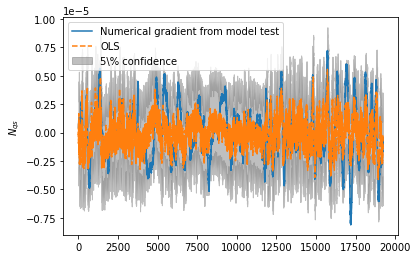

In [35]:
X = diff_eq_N.calculate_features(data=df_prime)
y = diff_eq_N.calculate_label(y=df_prime['N_qs'])

model_N = sm.OLS(y,X)
results_N = model_N.fit()

show_pred(X=X,y=y,results=results_N, label=r'$N_{qs}$')

## Y

In [36]:
Y_ = sp.symbols('Y_')
diff_eq_Y = regression.DiffEqToMatrix(ode=eq.Y_qs_eq.subs(Y_qs,Y_), 
                                      label=Y_, base_features=[delta,u,v,r])

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   Y_qs   R-squared (uncentered):                   0.997
Model:                            OLS   Adj. R-squared (uncentered):              0.997
Method:                 Least Squares   F-statistic:                          1.546e+06
Date:                Tue, 06 Jul 2021   Prob (F-statistic):                        0.00
Time:                        16:33:23   Log-Likelihood:                      1.8568e+05
No. Observations:               19222   AIC:                                 -3.714e+05
Df Residuals:                   19218   BIC:                                 -3.713e+05
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Ydelta         0.0009    1.5e-05     62.363      0.000       0.001       0.001
Yr             0.0132   2.99e-05    440.442      0.000       0.013       0.013
Yu         -5.526e-06   1.46e-07    -37.941      0.000   -5.81e-06   -5.24e-06
Yv            -0.0025   4.22e-05    -58.664      0.000      -0.003      -0.002
==============================================================================
Omnibus:                      282.527   Durbin-Watson:                   0.033
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              411.701
Skew:                           0.173   Prob(JB):                     3.98e-90
Kurtosis:                       3.628   Cond. No.                         452.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

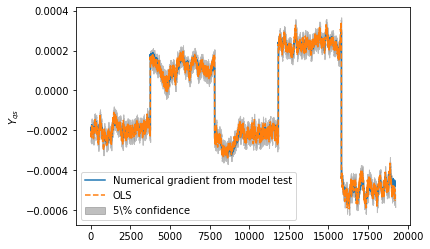

In [37]:
X = diff_eq_Y.calculate_features(data=df_prime)
y = diff_eq_Y.calculate_label(y=df_prime['Y_qs'])

model_Y = sm.OLS(y,X)
results_Y = model_Y.fit()

show_pred(X=X,y=y,results=results_Y, label=r'$Y_{qs}$')

## X

In [38]:
X_ = sp.symbols('X_')
diff_eq_X = regression.DiffEqToMatrix(ode=eq.X_qs_eq.subs(X_qs,X_), 
                                      label=X_, base_features=[delta,u,v,r])

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   X_qs   R-squared (uncentered):                   0.003
Model:                            OLS   Adj. R-squared (uncentered):              0.003
Method:                 Least Squares   F-statistic:                              16.38
Date:                Tue, 06 Jul 2021   Prob (F-statistic):                    2.12e-13
Time:                        16:33:23   Log-Likelihood:                      1.5942e+05
No. Observations:               19222   AIC:                                 -3.188e+05
Df Residuals:                   19218   BIC:                                 -3.188e+05
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Xdelta      2.578e-05   5.87e-05      0.439      0.661   -8.93e-05       0.000
Xr             0.0004      0.000      3.569      0.000       0.000       0.001
Xu         -1.595e-06   5.71e-07     -2.794      0.005   -2.71e-06   -4.76e-07
Xv             0.0008      0.000      4.981      0.000       0.000       0.001
==============================================================================
Omnibus:                    20699.288   Durbin-Watson:                   0.105
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1389933.637
Skew:                          -5.594   Prob(JB):                         0.00
Kurtosis:                      43.128   Cond. No.                         452.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

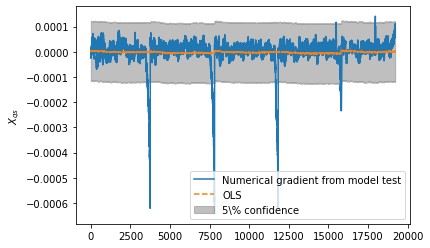

In [39]:
X = diff_eq_X.calculate_features(data=df_prime)
y = diff_eq_X.calculate_label(y=df_prime['X_qs'])

model_X = sm.OLS(y,X)
results_X = model_X.fit()

show_pred(X=X,y=y,results=results_X, label=r'$X_{qs}$')

In [40]:
results_summary_X = regression.results_summary_to_dataframe(results_X)
results_summary_Y = regression.results_summary_to_dataframe(results_Y)
results_summary_N = regression.results_summary_to_dataframe(results_N)

## Add the regressed parameters
Hydrodynamic derivatives that depend on acceleration cannot be obtained from the VCT regression. They are however essential if a time simulation should be conducted. These values have then been taken from Brix semi empirical formulas for the simulations below.

In [41]:
df_parameters_all = df_parameters.copy()
for other in [results_summary_X, results_summary_Y, results_summary_N]:
    df_parameters_all = df_parameters_all.combine_first(other)

df_parameters_all.rename(columns={'coeff':'regressed'}, inplace=True)
df_parameters_all.drop(columns=['brix_lambda'], inplace=True)

df_parameters_all['prime'] = df_parameters_all['regressed'].combine_first(df_parameters_all['brix_prime'])  # prefer regressed

In [42]:
df_parameters_all

,$P_{value}$,$conf_{higher}$,$conf_{lower}$,brix,brix_prime,regressed,coord,dof,state,symbol,prime
Ndelta,0.000000e+00,-1.671678e-04,-1.743515e-04,NaN,0.000000,-1.707597e-04,\delta,N,,N_{\delta},-1.707597e-04
Ndeltadot,NaN,NaN,NaN,NaN,0.000000,NaN,\delta,N,dot,N_{\dot{\delta}},0.000000e+00
Nr,0.000000e+00,-2.062065e-04,-2.205471e-04,-pi*T**2*(0.039*B/T - 0.56*B/L + 0.25)/L**2,-0.001719,-2.133768e-04,r,N,,N_{r},-2.133768e-04
Nrdot,NaN,NaN,NaN,-pi*T**2*(0.017*B*CB/T - 0.33*B/L + 0.08333333...,-0.000299,NaN,r,N,dot,N_{\dot{r}},-2.986748e-04
Nu,0.000000e+00,-7.909727e-07,-8.608296e-07,NaN,0.000000,-8.259011e-07,u,N,,N_{u},-8.259011e-07
Nudot,NaN,NaN,NaN,NaN,0.000000,NaN,u,N,dot,N_{\dot{u}},0.000000e+00
Nv,7.619210e-95,-9.707091e-05,-1.172934e-04,-pi*T**2*(0.5 + 2.4*T/L)/L**2,-0.003184,-1.071821e-04,v,N,,N_{v},-1.071821e-04
Nvdot,NaN,NaN,NaN,-pi*T**2*(-0.04*B/T + 1.1*B/L)/L**2,-0.000128,NaN,v,N,dot,N_{\dot{v}},-1.282544e-04
Xdelta,6.605524e-01,1.408641e-04,-8.929660e-05,NaN,0.000000,2.578374e-05,\delta,X,,X_{\delta},2.578374e-05
Xdeltadot,NaN,NaN,NaN,NaN,0.000000,NaN,\delta,X,dot,X_{\dot{\delta}},0.000000e+00


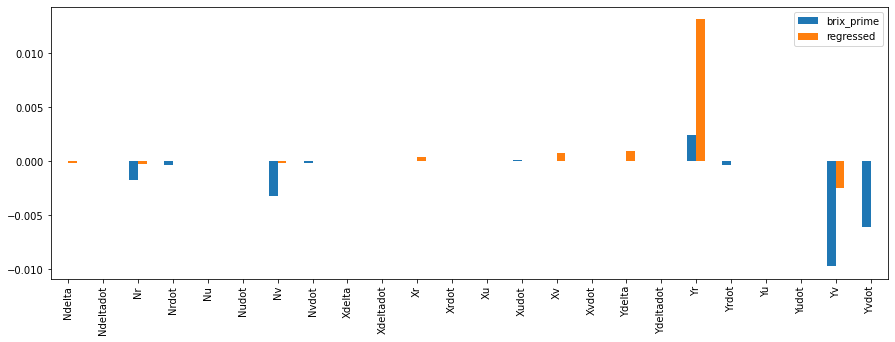

In [43]:
fig,ax=plt.subplots()
fig.set_size_inches(15,5)
df_parameters_all.plot.bar(y=['brix_prime','regressed'], ax=ax);

# Simulate captive

In [44]:
X_qs_lambda = lambdify(eq.X_qs_eq.rhs.subs(subs))
Y_qs_lambda = lambdify(eq.Y_qs_eq.rhs.subs(subs))
N_qs_lambda = lambdify(eq.N_qs_eq.rhs.subs(subs))

In [45]:
df_prime['X_qs_pred'] = run(function=X_qs_lambda, inputs=df_prime, **df_parameters_all['prime'])
df_prime['Y_qs_pred'] = run(function=Y_qs_lambda, inputs=df_prime, **df_parameters_all['prime'])
df_prime['N_qs_pred'] = run(function=N_qs_lambda, inputs=df_prime, **df_parameters_all['prime'])


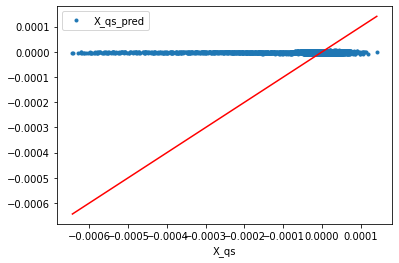

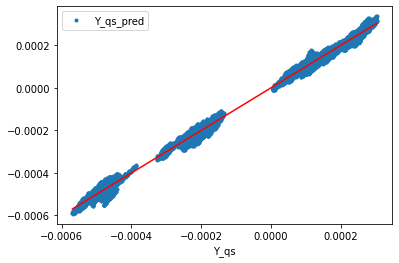

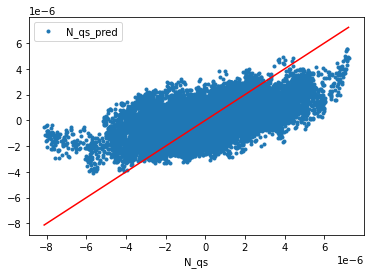

In [46]:
for key in ['X_qs','Y_qs','N_qs']:
    fig,ax=plt.subplots()
    df_prime.plot(x=key, y=f'{key}_pred',style='.', ax=ax)
    ax.plot([df_prime[key].min(), df_prime[key].max()], [df_prime[key].min(), df_prime[key].max()], 'r-')

# Simulation

In [47]:
df_ = df.copy()

def simulate(df_):

    t = df_.index
    control = df_[['delta']]
    #control = {'delta':0,}
    
    df_0 = df_.iloc[0:100].median(axis=0)
    y0 = {
        'u' : df_0['u'], 
        'v' : df_0['v'],
        'r' : df_0['r'],
        'x0' : df_0['x0'],
        'y0' : df_0['y0'],
        'psi' : df_0['psi'],
        }
    
    #solution = model.simulate(y0=y0, t=t, df_parameters=df_parameters, df_ship_parameters=df_ship_parameters, control=control, rtol=1e-3, atol=1e-3)
    solution = model.simulate(y0=y0, t=t, df_parameters=df_parameters_all, ship_parameters=ship_parameters, control=control)
    
    columns = list(y0.keys())
    df_result_prime = pd.DataFrame(data=solution.y.T, columns=columns)
    df_result_prime.index=t[0:len(df_result_prime)]
    
    U_ = np.sqrt(df_0['u']**2 + df_0['v']**2)
    df_result = ps.unprime(values=df_result_prime, U=U_)
    df_result['beta'] = -np.arctan2(df_result['v'],df_result['u'])
    return df_result


In [48]:
df_result = pd.DataFrame()
for id,group in df.groupby(by='id'):
    
    df_ = group.set_index('t')
    df_result_ = simulate(df_)
    df_result_['id'] = id
    df_result_['t'] = df_result_.index
    df_result = df_result.append(df_result_, ignore_index=True)
    

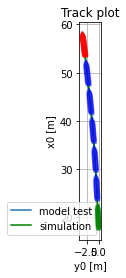

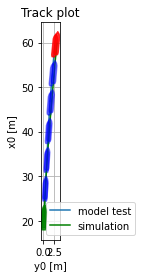

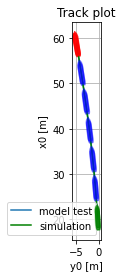

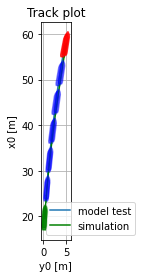

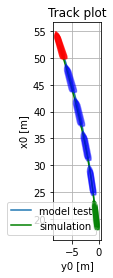

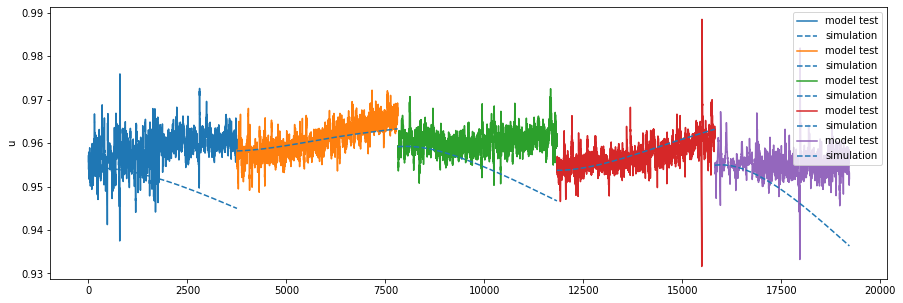

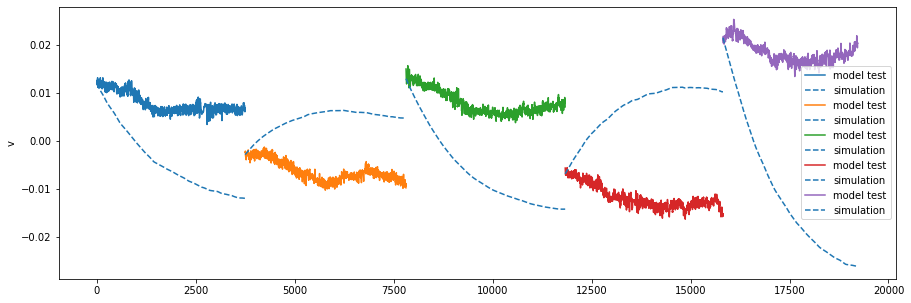

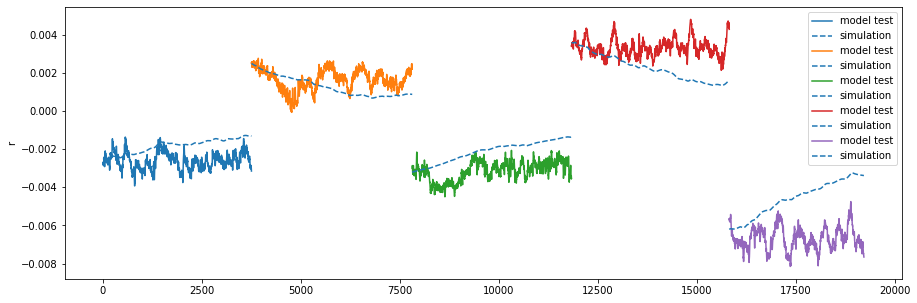

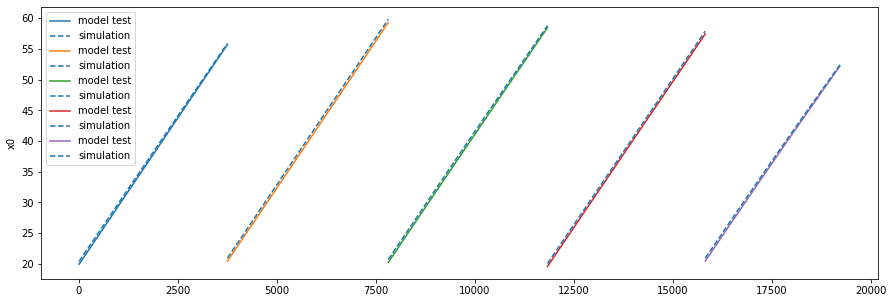

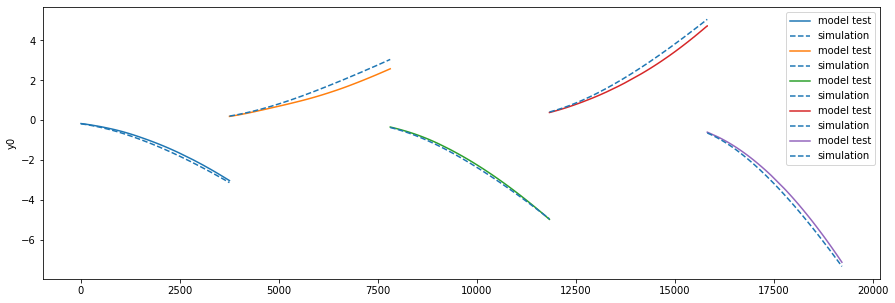

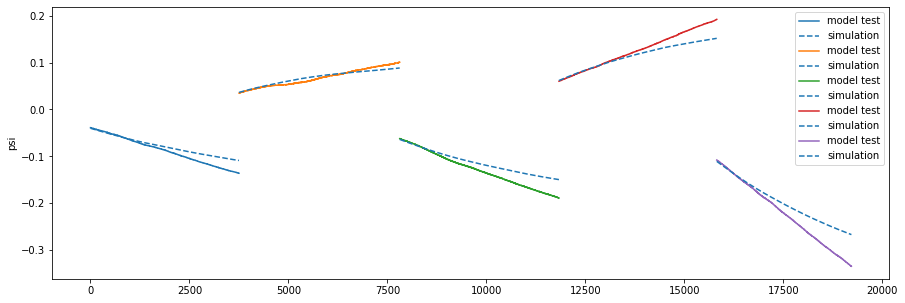

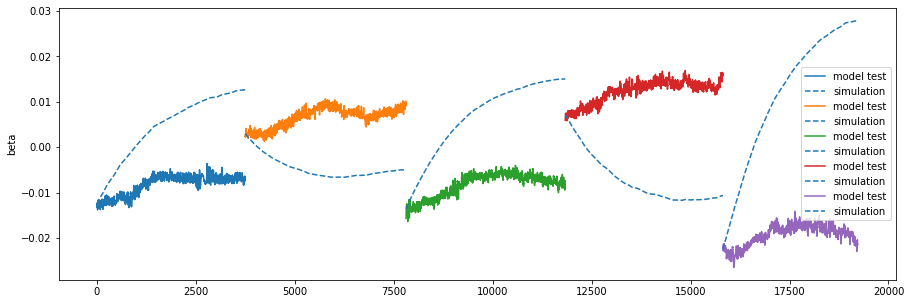

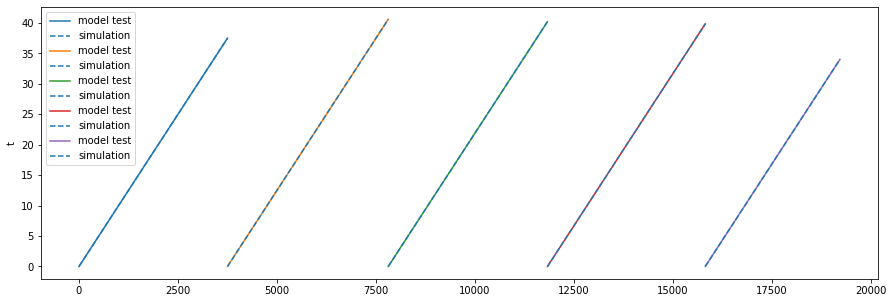

In [49]:
groups = df.groupby(by='id')
for id,group in df_result.groupby(by='id'):
    fig,ax=plt.subplots()
    track_plot(df=groups.get_group(id), lpp=ship_parameters['L'], beam=ship_parameters['B'],ax=ax, label='model test')
    track_plot(df=group, lpp=ship_parameters['L'], beam=ship_parameters['B'],ax=ax, label='simulation', color='green')
    ax.legend()

for key in df_result:
    
    if key=='id':
        continue
    
    fig,ax = plt.subplots()
    fig.set_size_inches(15,5)
        
    for id,group in df_result.groupby(by='id'):
        plot = groups.get_group(id).plot(y=key, label='model test', ax=ax)
        
        color = plot.lines[0].get_color()
        group.plot(y=key, label='simulation', color=color, style='--', ax=ax)
        ax.set_ylabel(key)

